### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

### Import Data

In [2]:
star = pd.read_csv ('https://github.com/YBIFoundation/Dataset/raw/main/Stars.csv')
star.head()

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star type,Star category,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,0,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,0,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,0,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,0,Brown Dwarf,Red,M


### EDA

In [3]:
star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Temperature (K)          240 non-null    int64  
 1   Luminosity (L/Lo)        240 non-null    float64
 2   Radius (R/Ro)            240 non-null    float64
 3   Absolute magnitude (Mv)  240 non-null    float64
 4   Star type                240 non-null    int64  
 5   Star category            240 non-null    object 
 6   Star color               240 non-null    object 
 7   Spectral Class           240 non-null    object 
dtypes: float64(3), int64(2), object(3)
memory usage: 15.1+ KB


In [4]:
star.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity (L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius (R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude (Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


#### Detecting categorical and numerical features

In [5]:
# remove 'star type' column, because we don't need it 
num_cols = ['Temperature (K)', 'Luminosity (L/Lo)', 'Radius (R/Ro)', 'Absolute magnitude (Mv)']
cat_cols = ['Star category', 'Star color', 'Spectral Class']

#### Checking number of uniques in categorical features

In [6]:
star[cat_cols].nunique()

Star category      6
Star color        19
Spectral Class     7
dtype: int64

#### Check duplicates

In [7]:
star[star.duplicated()]
# star.drop_duplicates(inplace=True)

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star type,Star category,Star color,Spectral Class


#### Check outliers

In [8]:
px.box(data_frame=star[num_cols])

#### Detecting outliers with IQR

In [9]:
q1 = star[num_cols].quantile(0.25)
q3 = star[num_cols].quantile(0.75)
IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# filling the outliers with nan, because outliers are not low compared to the total data(specialy in Radius (R/Ro))
star[num_cols] = np.where((star[num_cols] < lower_bound) | (star[num_cols] > upper_bound), np.nan, star[num_cols])

In [10]:
px.box(data_frame=star[num_cols])

#### Missing values

In [11]:
star.isnull().sum()

Temperature (K)            11
Luminosity (L/Lo)          12
Radius (R/Ro)              40
Absolute magnitude (Mv)     0
Star type                   0
Star category               0
Star color                  0
Spectral Class              0
dtype: int64

#### Filling missing values with the most frequent data

In [12]:
most_freq_imp = SimpleImputer(strategy= 'most_frequent')
star.iloc[:,:] = most_freq_imp.fit_transform(star)

#### Encoding

In [13]:
encoded_features = star[cat_cols].apply(LabelEncoder().fit_transform)

In [14]:
cols = [star[num_cols], encoded_features]
star_new = pd.concat(cols, axis= 1)
star_new

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star category,Star color,Spectral Class
0,3068.0,0.002400,0.1700,16.12,0,10,5
1,3042.0,0.000500,0.1542,16.60,0,10,5
2,2600.0,0.000300,0.1020,18.70,0,10,5
3,2800.0,0.000200,0.1600,16.65,0,10,5
4,1939.0,0.000138,0.1030,20.06,0,10,5
...,...,...,...,...,...,...,...
235,3600.0,374830.000000,0.1100,-9.93,1,0,6
236,30839.0,200000.000000,0.1100,-10.63,1,0,6
237,8829.0,200000.000000,0.1100,-10.73,1,11,0
238,9235.0,404940.000000,0.1100,-11.23,1,11,0


#### Defining features and target

In [15]:
y = star_new['Spectral Class']
X = star_new.drop(columns='Spectral Class')

#### Seprating data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 200)

#### Scaling data

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [18]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Modeling 

>#### Decision Tree

In [19]:
model = DecisionTreeClassifier(max_depth= 7, random_state= 18)

In [20]:
model.fit(X_train_scaled,y_train)

DecisionTreeClassifier(max_depth=7, random_state=18)

In [21]:
y_pred = model.predict(X_test_scaled)

In [22]:
confusion_matrix(y_test,y_pred)

array([[ 4,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  1],
       [ 0,  1,  3,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0, 18,  0],
       [ 0,  1,  0,  0,  0,  8]], dtype=int64)

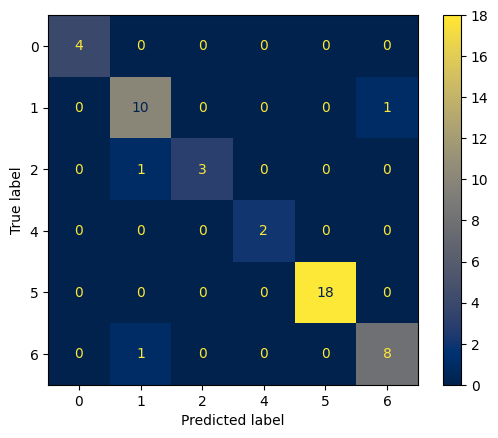

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap= 'cividis')

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)

print(f'Average Score: {scores.mean()}')

Average Score: 0.9083333333333334


In [25]:
print(accuracy_score(y_test, y_pred))

0.9375


In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      0.91      0.87        11
           2       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00        18
           6       0.89      0.89      0.89         9

    accuracy                           0.94        48
   macro avg       0.95      0.92      0.94        48
weighted avg       0.94      0.94      0.94        48



>#### Gradient Boosting

In [27]:
model_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=40)

In [28]:
model_2.fit(X_train, y_train)

GradientBoostingClassifier(random_state=40)

In [29]:
y_pred_2 = model_2.predict(X_test)

In [30]:
confusion_matrix(y_test,y_pred_2)

array([[ 4,  0,  0,  0,  0,  0],
       [ 1,  9,  0,  0,  0,  1],
       [ 0,  1,  3,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0, 18,  0],
       [ 0,  1,  0,  0,  0,  8]], dtype=int64)

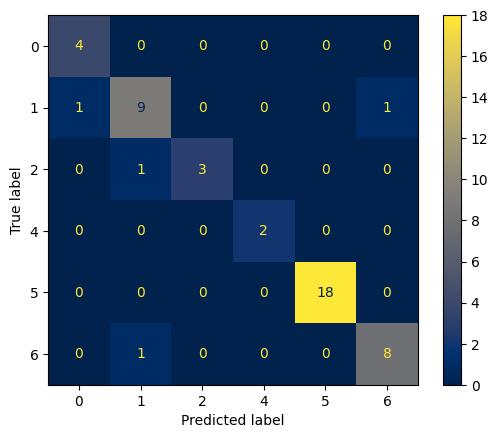

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, cmap= 'cividis')

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_2, X, y, cv=kf)

print(f'Average Score: {scores.mean()}')

Average Score: 0.9291666666666666


In [33]:
print(accuracy_score(y_test, y_pred_2))

0.9166666666666666


In [34]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.82      0.82      0.82        11
           2       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00        18
           6       0.89      0.89      0.89         9

    accuracy                           0.92        48
   macro avg       0.92      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48

